In [ ]:
# Import libraries
import requests
from bs4 import BeautifulSoup 
import pandas as pd  
from flair.models import TextClassifier
from flair.data import Sentence
from flair.splitter import SegtokSentenceSplitter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


In [ ]:
# Load Flair sentiment classifier
classifier = TextClassifier.load("en-sentiment")  # Currently using the general sentiment model
splitter = SegtokSentenceSplitter()

In [ ]:
# Scrape and extract Abraham Lincoln's speeches from Project Gutenberg
lincoln_url = "https://www.gutenberg.org/cache/epub/14721/pg14721-images.html"
lincoln_html = requests.get(lincoln_url)
lincoln_soup = BeautifulSoup(lincoln_html.content, "html.parser")

# Combine all <p> paragraph elements that have more than 40 characters of actual text.
# This filters out short labels, page numbers, and empty lines.
lincoln_text = "\n".join([
    p.get_text(strip=True)
    for p in lincoln_soup.find_all("p")
    if len(p.get_text(strip=True)) > 40
])


In [ ]:
# Scrape and extract Benjamin Harrison's speeches from Project Gutenberg
harrison_url = "https://www.gutenberg.org/cache/epub/44682/pg44682-images.html"
harrison_html = requests.get(harrison_url)
harrison_soup = BeautifulSoup(harrison_html.content, "html.parser")

# Join all paragraph <p> tags that contain more than 40 characters of actual text
# Filters out noise like headings, numbers, and empty tags
harrison_text = "\n".join([
    p.get_text(strip=True)
    for p in harrison_soup.find_all("p")
    if len(p.get_text(strip=True)) > 40
])


In [ ]:
# Split full speeches using Flair's sentence splitter
lincoln_sentences = splitter.split(lincoln_text)     # All sentences from Lincoln
harrison_sentences = splitter.split(harrison_text)   # All sentences from Harrison

print(f"Total Lincoln sentences: {len(lincoln_sentences)}")
print(f"Total Harrison sentences: {len(harrison_sentences)}")


In [ ]:
# Analyze each sentence and return structured info
def analyze_sentences(sentences, label):
    results = []
    for sent in sentences:
        classifier.predict(sent)
        sentiment = sent.labels[0]
        results.append({
            "text": sent.to_plain_string(),
            "sentiment": sentiment.value,
            "confidence": round(sentiment.score, 4),
            "source": label
        })
    return results

# Run analysis
lincoln_results = analyze_sentences(lincoln_sentences, "Lincoln") 
harrison_results = analyze_sentences(harrison_sentences, "Harrison")

# Create combined DataFrame
df = pd.DataFrame(lincoln_results + harrison_results)
df.head()

In [7]:
# File 1: Sentence-level sentiment analysis (includes all key columns)
df.to_csv("sentence_level_sentiments.csv", index=False)

# File 2: Summary of sentiment distribution and intensity by president
summary = (
    df.groupby(["source", "sentiment"])
      .agg(sentence_count=("text", "count"), avg_confidence=("confidence", "mean"))
      .reset_index()
)
summary.to_csv("sentiment_summary_by_president.csv", index=False)

# File 3: Raw scraped speech text (for archival/human readability)
with open("lincoln_harrison_raw_text.txt", "w", encoding="utf-8") as f:
    f.write("=== ABRAHAM LINCOLN SPEECHES ===\n")
    f.write(lincoln_text)
    f.write("\n\n=== BENJAMIN HARRISON SPEECHES ===\n")
    f.write(harrison_text)



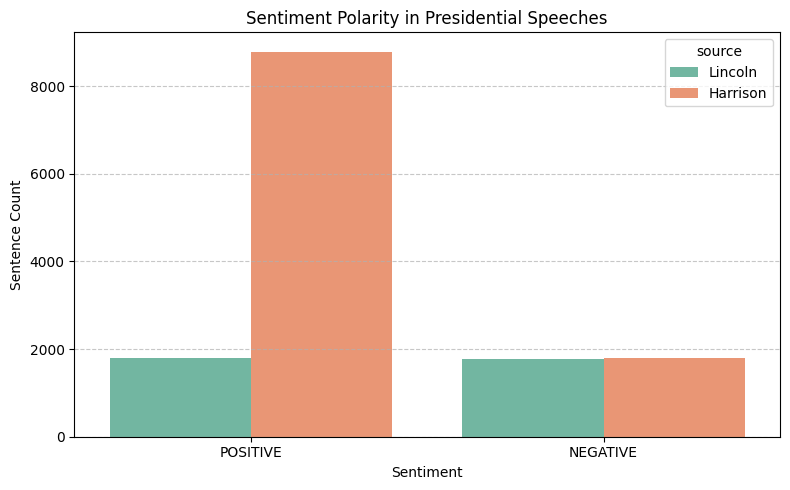

In [8]:
#Distribution of Positive and Negative Sentences in Presidential Speeches
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="sentiment", hue="source", palette="Set2")
plt.title("Sentiment Polarity in Presidential Speeches")
plt.xlabel("Sentiment")
plt.ylabel("Sentence Count")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


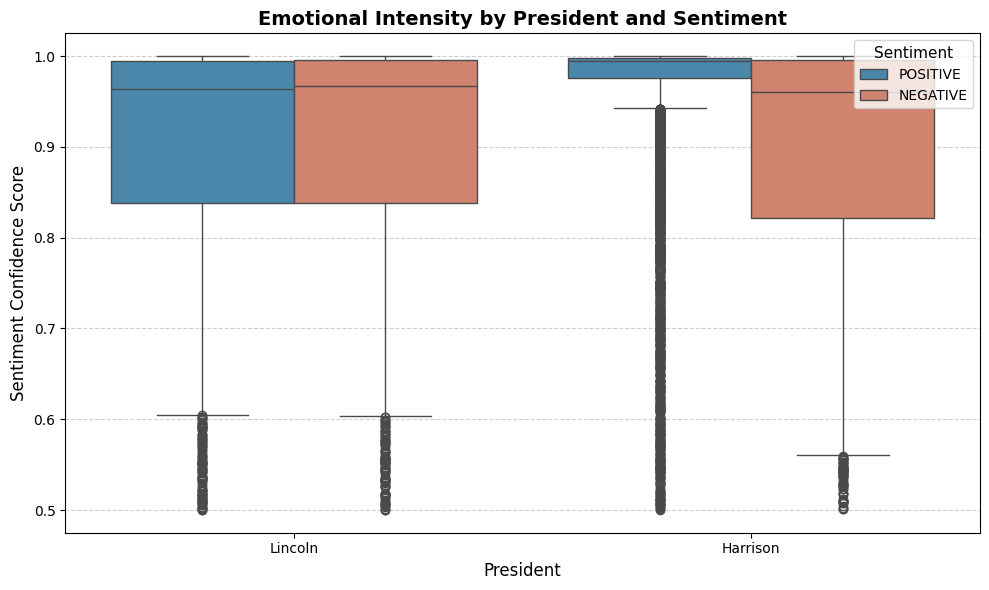

In [9]:
#Comparison of Emotional Intensity by Sentiment and President
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df,
    x="source",         # Lincoln or Harrison
    y="confidence",     # Sentiment intensity
    hue="sentiment",    # Positive or Negative
    palette={"POSITIVE": "#3b8bba", "NEGATIVE": "#e07a5f"},
    linewidth=1
)

# Title and axis labels
plt.title("Emotional Intensity by President and Sentiment", fontsize=14, weight='bold')
plt.xlabel("President", fontsize=12)
plt.ylabel("Sentiment Confidence Score", fontsize=12)

# Optional: Customize legend
plt.legend(title="Sentiment", title_fontsize=11, fontsize=10, loc="upper right")

# Improve grid
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


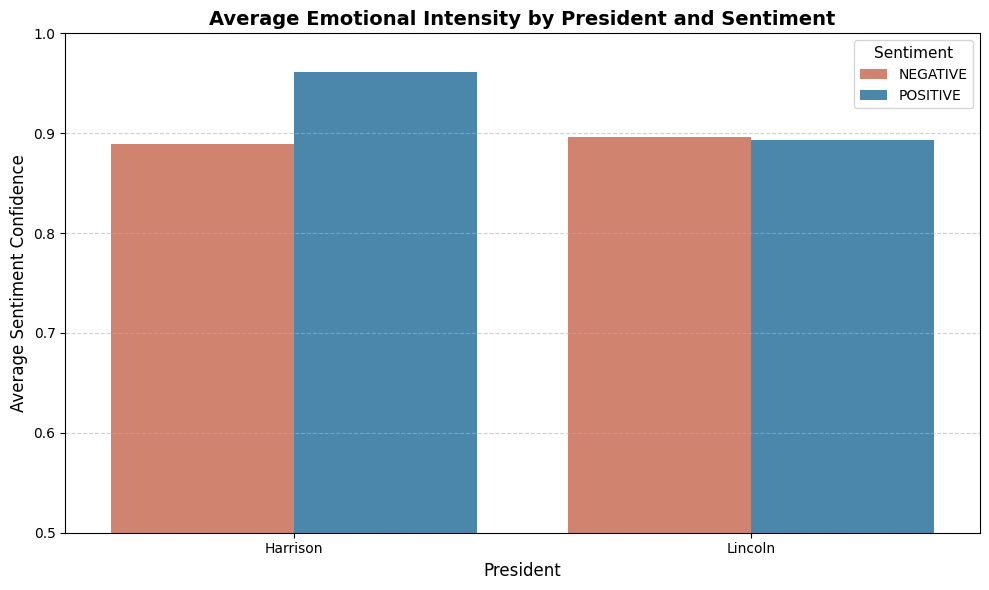

In [ ]:
# Compare mean confidence scores (emotional intensity) by president
# Group by president and sentiment to calculate average confidence
avg_conf = df.groupby(["source", "sentiment"]).agg(
    sentence_count=("text", "count"),
    avg_confidence=("confidence", "mean")
).reset_index()

plt.figure(figsize=(10, 6))

sns.barplot(
    data=avg_conf, 
    x="source", 
    y="avg_confidence",   
    hue="sentiment", 
    palette={"POSITIVE": "#3b8bba", "NEGATIVE": "#e07a5f"}
)

plt.title("Average Emotional Intensity by President and Sentiment", fontsize=14, weight='bold')
plt.xlabel("President", fontsize=12)
plt.ylabel("Average Sentiment Confidence", fontsize=12)
plt.ylim(0.5, 1.0)
plt.legend(title="Sentiment", title_fontsize=11)
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

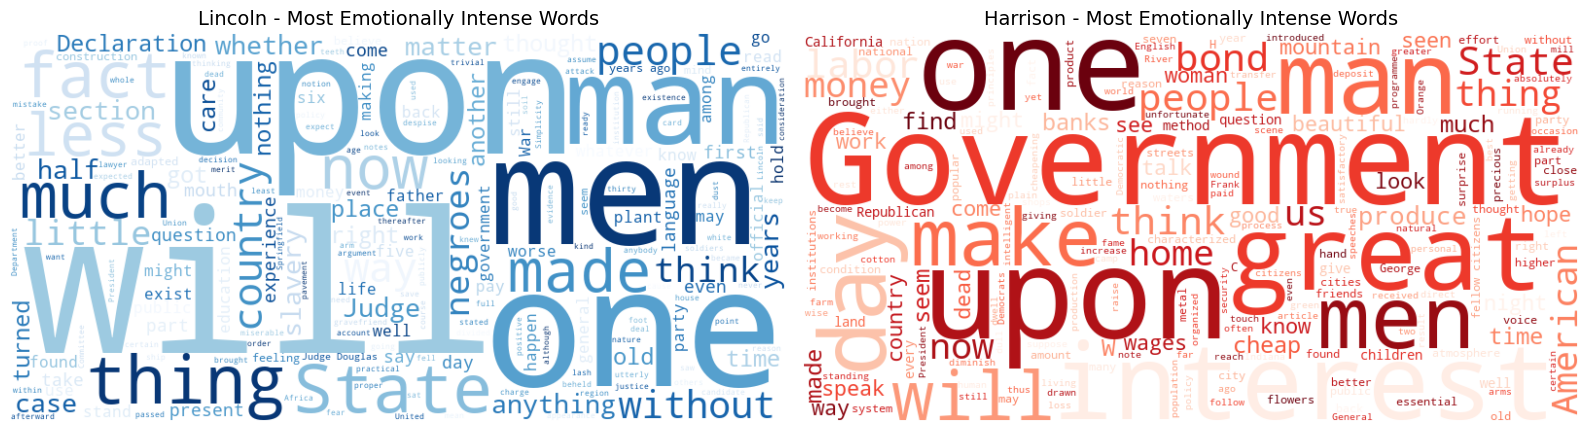

In [13]:
# Filter top 100 emotionally intense sentences for each president
top_lincoln = df[df['source'] == "Lincoln"].sort_values(by="confidence", ascending=False).head(100)
top_harrison = df[df['source'] == "Harrison"].sort_values(by="confidence", ascending=False).head(100)

# Join sentences for word cloud
lincoln_text_wc = " ".join(top_lincoln["text"])
harrison_text_wc = " ".join(top_harrison["text"])

# Generate word clouds
lincoln_wc = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(lincoln_text_wc)
harrison_wc = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(harrison_text_wc)

# Plot side-by-side
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(lincoln_wc, interpolation='bilinear')
plt.axis("off")
plt.title("Lincoln - Most Emotionally Intense Words", fontsize=14)

plt.subplot(1, 2, 2)
plt.imshow(harrison_wc, interpolation='bilinear')
plt.axis("off")
plt.title("Harrison - Most Emotionally Intense Words", fontsize=14)

plt.tight_layout()
plt.show()
